<center>
<h1>COMP4680/8650: Advanced Topics in Machine Learning</h1>
<h2>Assignment #5: Programming Assignment</h2>
Semester 2, 2022<br>
</center>
    
**Due**: 11:55pm on Sunday 16 October, 2022.<br>
Submit as a single Jupyter Notebook via Wattle. Make sure that your name and student ID appears in the section below. Cite all sources.

---

**Name:** Hengcheng Zhang
<br>
**Student ID:** u7096187

---

This assignment gives you an opportunity to explore applications of convex optimization and actually
solve some convex programs. We will provide you with starter Python code and comments on where you
are expected to complete the implementation.

For part of the assignment you will be using the Python package CVXPY (version 1.2), which can be
downloaded from http://www.cvxpy.org/. Follow the installation instructions and browse through
some of the user documentation (we will step you through most of what you need to know for solving
the problems in this assignment).

**Run all code blocks from start to end (`Restart & Run All`) and then save your Jupyter Notebook
before submitting your assignment to ensure everything works as expected.**

In [1]:
# %matplotlib notebook
# %matplotlib inline

import numpy as np
import numpy.random as rnd

import cvxpy as cvx

import matplotlib.pyplot as plt

# 1. Unconstrained Optimization (60 marks)

In this question you will complete an implementation of Newton's method for solving the following unconstrained convex optimization problem,

$$
    \text{minimize} \quad f(x) \triangleq - \sum_{i=1}^{n} \log (2 - x_i^2) - \sum_{i=1}^{m} \log (b_i - a_i^T x)
$$

Data for the problem is generated randomly as

$$
    A = \begin{bmatrix} a_1^T \\ a_2^T \\ \vdots \\ a_m^T \end{bmatrix} \in \mathbb{R}^{m \times n}
    \quad \text{and} \quad
    b \in \mathbb{R}_{++}^{m}
$$

Since $b \succ 0$ we know that $x = 0$ is a feasible point for initialising our optimization algorithm.

In [2]:
# generate a problem instance
rnd.seed(4680)

m = 1000
n = 100
A = rnd.randn(m, n)
b = rnd.rand(m, 1)

## (a) Derive an expression for the gradient $g = \nabla f(x)$

$\nabla f(x) = \begin{bmatrix} g_1 \\ g_2 \\ \vdots \\ g_m \end{bmatrix}$, where $g_i = \frac{2x_i}{2-x_i^2} + \sum_{j=1}^m\frac{a_{j,i}}{b_j - a_j^T x}$


## (b) Derive an expression for the Hessian $H = \nabla^2 f(x)$

Let $h_{j,k}$ denotes the element in $j_{\text{th}}$ row and $k_{\text{th}}$ column of Hessian,

$\begin{aligned} \nabla^2 f(x) &= \frac{\partial^2}{\partial x_j \partial x_k} f(x)\\
& = \frac{\partial}{\partial x_k} \left( \frac{2x_{j}}{2-x_{j}^2} + \sum_{i=1}^m\frac{a_{i,j}}{b_i - a_i^T x}\right)\\
& = \frac{2(2+x_{j=k}^2)}{\left( 2-x_{j=k}^2\right)^2} + \sum_{i=1}^m\frac{a_{i,j} \cdot a_{i,k}^T}{(b_i - a_i^T x)^2}\\
& = \text{diag}\left(\frac{4+2x_i^2}{\left(2-x_i^2\right)^2}\right) + \sum_{i=1}^m\frac{a_{i} \cdot a_{i}^T}{(b_i - a_i^T x)^2}
\end{aligned}$

## (c) Complete functions `objective(x)`, `gradient(x)` and `hessian(x)` below

In [3]:
def objective(x):
    """Returns the value of the objective function at x."""

    r = b - A @ x
    if (pow(x, 2) >= 2).any() or (r <= 0).any():
        # raise ValueError("the input x is not in domain")
        return np.Infinity
    return -1 * np.sum(np.log(2 - pow(x, 2))) - np.sum(np.log(r))


def gradient(x):
    """Returns the gradient of the objective function at x."""

    return 2 * x / (2 - pow(x, 2)) + (A.T @ (1 / (b - A @ x)))


def hessian(x):
    """Returns the Hessian of the objective function at x."""

    h = np.diag((4 + 2 * pow(x, 2)) / pow(2 - pow(x, 2), 2))
    for i in range(A.shape[0]):
        a_i = A[i, :].reshape([n, 1])
        h = h + ((a_i @ a_i.T) / pow(b[i] - a_i.T @ x, 2))
    return h


## (d) Implement the `linesearch(...)` function

In [4]:
def linesearch(f, df, x, dx, alpha=0.3, beta=0.7):
    """
    Implements backtracking line search on function f. See B&V Algorithm 9.2.

    :param f: The function being optimized.
    :param df: Gradient of the function at x.
    :param x: Starting point for line search.
    :param dx: Direction of line search.
    :param alpha: Line search parameter for stopping criteria.
    :param beta: Line search parameter for reducing step size.
    :return: Step size t.
    """

    t = 1.0
    delta_x = alpha * (df.T @ dx)
    while f(x + t * dx) > f(x) + t * delta_x:
        t = beta * t
    return t



## (e) Run the following code block to test your code

The implementation of `gradient_descent` and `newton` are provided for you. Both use the `linesearch` function you implemented above for backtracking line search. You simply need to run the code.

In [5]:
# import numba

# @numba
def gradient_descent(x, f, g, eps=1.0e-6, max_iters=200, alpha=0.3, beta=0.7):
    """
    Implements gradient descent to minimize function f. See B&V Algorithm 9.3.

    :param x: Starting point in domain of f.
    :param f: The function to be optimized. Returns scalar.
    :param g: The gradient function. Returns vector in R^n.
    :param eps: Tolerance for stopping.
    :param max_iters: Maximum number of iterations for stopping.
    :param alpha: Backtracking line search parameter.
    :param beta: Backtracking line search parameter.
    :return: Optimization path (i.e., array of x's). The last point is the optimal point.
    """

    path = [x.copy()]

    for iter in range(max_iters):
        # Compute gradient
        dx = -1.0 * g(x)

        # Stopping criterion
        print("...iter {}, f(x) = {}".format(iter, f(x)))
        if np.linalg.norm(dx) <= eps:
            break

        # Line search
        t = linesearch(f, g(x), x, dx, alpha, beta)

        # Update
        x += t * dx
        path.append(x.copy())

    return path

# @numba
def newton(x, f, g, H, eps=1.0e-6, max_iters=200, alpha=0.3, beta=0.7):
    """
    Implements Newton's method to minimize function f. See B&V Algorithm 9.5.

    :param x: Starting point in domain of f.
    :param f: The function to be optimized. Returns scalar.
    :param g: The gradient function. Returns vector in R^n.
    :param H: The Hessian function. Returns matrix in R^{n \times n}.
    :param eps: Tolerance for stopping.
    :param max_iters: Maximum number of iterations for stopping.
    :param alpha: Backtracking line search parameter.
    :param beta: Backtracking line search parameter.
    :return: Optimization path (i.e., array of x's). The last point is the optimal point.
    """

    # Initialize optimization path
    path = [x.copy()]

    for iter in range(max_iters):
        # Compute Newton step and decrement
        dx = -1.0 * np.linalg.solve(H(x), g(x))
        lmd2 = -1.0 * np.dot(g(x).T, dx)

        # Stopping criterion
        print("...iter {}, f(x) = {}".format(iter, f(x)))
        if 0.5 * lmd2 <= eps:
            break

        # Line search
        t = linesearch(f, g(x), x, dx, alpha, beta)

        # Update
        x += t * dx
        path.append(x.copy())

    return path

# --- test -----------------------------------------------------------------------------------------------

# solve using gradient descent
gd_path = gradient_descent(np.zeros((n, 1)), objective, gradient)

# solve using newton's method
nm_path = newton(np.zeros((n, 1)), objective, gradient, hessian)

if objective(nm_path[-1]) < objective(gd_path[-1]):
    x_star = nm_path[-1]
else:
    x_star = gd_path[-1]
p_star = objective(x_star)

# plot
plt.figure(figsize=[13,8])
plt.semilogy(range(len(gd_path)), [objective(x) - p_star for x in gd_path], lw=2)
plt.semilogy(range(len(nm_path)), [objective(x) - p_star for x in nm_path], lw=2)
plt.xlabel("$k$"); plt.ylabel(r"$f(x) - p^\star$")
plt.legend(["Gradient Descent", "Newton's Method"])
plt.show()

...iter 0, f(x) = 935.9465337973118
...iter 1, f(x) = 920.8874672595048
...iter 2, f(x) = 898.141670311304
...iter 3, f(x) = 882.7267869279245
...iter 4, f(x) = 866.1829354221195
...iter 5, f(x) = 850.0383843595188
...iter 6, f(x) = 847.4759644761663
...iter 7, f(x) = 831.7586301841712
...iter 8, f(x) = 828.9763948262356
...iter 9, f(x) = 822.4266468668213
...iter 10, f(x) = 820.5734983495607
...iter 11, f(x) = 817.7050273628056
...iter 12, f(x) = 814.5686726310125
...iter 13, f(x) = 811.8353407104214
...iter 14, f(x) = 810.1253669458548
...iter 15, f(x) = 808.3983419195387
...iter 16, f(x) = 807.2049684217538
...iter 17, f(x) = 806.288021677966
...iter 18, f(x) = 805.3988855832938
...iter 19, f(x) = 804.7428866987262
...iter 20, f(x) = 804.2071174623153
...iter 21, f(x) = 803.7546876217224
...iter 22, f(x) = 803.3870533301043
...iter 23, f(x) = 803.0745008708681
...iter 24, f(x) = 802.8013298497568
...iter 25, f(x) = 802.589811461307
...iter 26, f(x) = 802.3800990542343
...iter 27, f(

## (f) Implement gradient descent without line search

We will implement gradient descent with a fixed step size and decaying step size schedule. This is commonly done when evaluating the function (i.e., performing line search) is expensive. However, the cost is often more iterations of the optimisation algorithm. Pseudo-code for the algorithm is

---

**given** a starting point $x \in \textbf{dom} f$, a starting step size $t > 0$, and decay rate $0 < \gamma \leq 1$

**repeat**
1. $\Delta x_{nsd} := −\nabla f(x) / \|\nabla f(x)\|$.
2. if $x + t \Delta x_{nsd}$ feasible, then $x := x + t \Delta x_{nsd}$.
3. $t := \gamma t$.

**until** stopping criterion is satisfied.

---

...iter 0, f(x) = 935.9465337973118
...iter 1, f(x) = 928.1024274385286
...iter 2, f(x) = 922.5724940268689
...iter 3, f(x) = 918.1661089718273
...iter 4, f(x) = 914.3842702383205
...iter 5, f(x) = 911.0131786438006
...iter 6, f(x) = 907.9408361232785
...iter 7, f(x) = 905.1006184941024
...iter 8, f(x) = 902.4488647567251
...iter 9, f(x) = 899.9548503843946
...iter 10, f(x) = 897.5958084980721
...iter 11, f(x) = 895.3541947903357
...iter 12, f(x) = 893.2160563912901
...iter 13, f(x) = 891.1700001223949
...iter 14, f(x) = 889.2065149364565
...iter 15, f(x) = 887.3175185106284
...iter 16, f(x) = 885.4960525848926
...iter 17, f(x) = 883.7360783628617
...iter 18, f(x) = 882.0323368698312
...iter 19, f(x) = 880.3802475419016
...iter 20, f(x) = 878.7758257918518
...iter 21, f(x) = 877.2156081185744
...iter 22, f(x) = 875.6965804845152
...iter 23, f(x) = 874.216110547276
...iter 24, f(x) = 872.7718862244559
...iter 25, f(x) = 871.3618626721478
...iter 26, f(x) = 869.984218377362
...iter 27, f

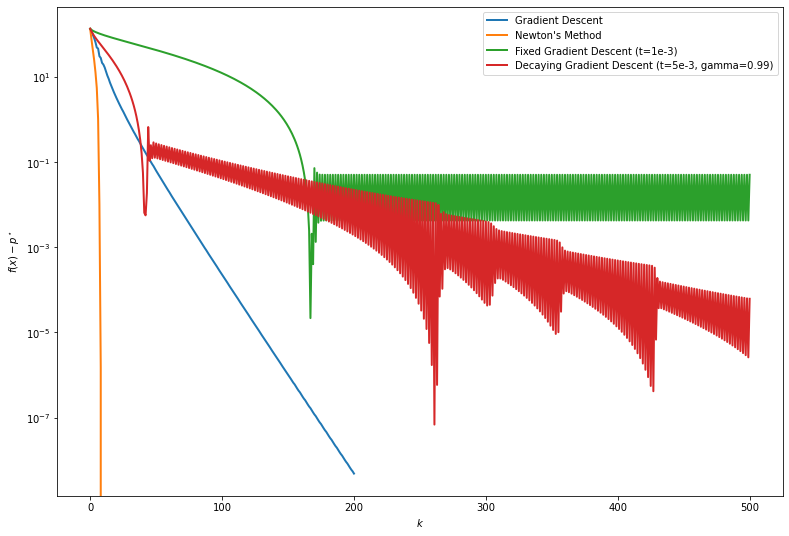

In [6]:
def gradient_descent_no_linesearch(x, f, g, eps=1.0e-6, max_iters=500, t=1.0e-3, gamma=1.0):
    """
    Implements gradient descent with fixed step size to minimize function f.

    :param x: Starting point in domain of f.
    :param f: The function to be optimized. Returns scalar.
    :param g: The gradient function. Returns vector in R^n.
    :param eps: Tolerance for stopping.
    :param max_iters: Maximum number of iterations for stopping.
    :param t: Initial step size parameter.
    :param gamma: Step size decay schedule (set to 1.0 for fixed step size).
    :return: Optimization path (i.e., array of x's). The last point is the optimal point.
    """

    path = [x.copy()]

    for iter in range(max_iters):
        # Compute gradient
        dx = -1.0 * g(x)

        # Stopping criterion
        print("...iter {}, f(x) = {}".format(iter, f(x)))
        if np.linalg.norm(dx) <= eps:
            break

        # Update
        dx = dx / np.linalg.norm(dx)
        # Check if x is infeasible
        if f(x + t * dx) != np.Infinity:
            x += t * dx
        t = gamma * t
        path.append(x.copy())

    return path

# --- test -----------------------------------------------------------------------------------------------


# solve using gradient descent with fixed step size
gd_fixed = gradient_descent_no_linesearch(
    np.zeros((n, 1)), objective, gradient, t=1.0e-3)

# solve using gradient descent with decaying step size
gd_decay = gradient_descent_no_linesearch(
    np.zeros((n, 1)), objective, gradient, t=5.0e-3, gamma=0.99)

# plot
plt.figure(figsize=[13,9])
plt.semilogy(range(len(gd_path)), [
             objective(x) - p_star for x in gd_path], lw=2)
plt.semilogy(range(len(nm_path)), [
             objective(x) - p_star for x in nm_path], lw=2)
plt.semilogy(range(len(gd_fixed)), [
             objective(x) - p_star for x in gd_fixed], lw=2)
plt.semilogy(range(len(gd_decay)), [
             objective(x) - p_star for x in gd_decay], lw=2)
plt.xlabel("$k$")
plt.ylabel(r"$f(x) - p^\star$")
plt.legend(["Gradient Descent", "Newton's Method", "Fixed Gradient Descent (t=1e-3)",
           "Decaying Gradient Descent (t=5e-3, gamma=0.99)"])
plt.show()


## (g) What can you say about the speed of convergence of Newton's method compared to gradient descent? What can you say about line search compared to no line search?

The Newton's Method has a much faster speed of convergence compared to Gradient Descent. Newton's Method takes less than 100 iterations to reach a relatively small error buy Gradient Descent takes about 200 iterations.

Method with linesearch also has a faster speed of convergence than methods with no linesearch.

# 2. Linear Programming (20 marks)

Write a Python script using `cvx` to solve the following linear over $x \in \mathbb{R}^4$:

$$
\begin{array}{ll}
    \text{minimize} & 8x_1 + 6x_2 + 5x_3 + 0x_4 \\
    \text{subject to} & x_1 + x_2 + x_3 + x_4 = 1 \\
    & x_1 - x_2 + x_3 - x_4 = 0 \\
    & x_1, x_2, x_3, x_4 \geq 0
\end{array}
$$

Include a printout of the optimal value and solution ($p^\star$ and $x^\star$).

In [7]:
n = 4
c = np.array([8, 6, 5, 0])
A = np.array([[1, 1, 1, 1], [1, -1, 1, -1]])
b = np.array([1, 0])

x = cvx.Variable(n)
objective = cvx.Minimize(c @ x)
constraints = [A @ x == b, x>=0]
p = cvx.Problem(objective, constraints)
p.solve()

print("p^\\star is {}".format(p.value))
print("x^\\star is {}".format(x.value.transpose()))

p^\star is 2.5000000047504614
x^\star is [1.18300841e-09 2.00187873e-10 4.99999999e-01 5.00000000e-01]


# 3. Total Variation Denoising (20 marks)

In this question we investigate the problem of signal denoising.
Consider a signal $x \in \mathbb{R}^n$ corrupted by noise.
We measure the corrupted signal $x_{\text{corr}}$ and wish to recover a good estimate $\hat{x}$ of the original signal.
To do this we solve the total variation denoising problem

$$
    \text{minimize} \quad \|\hat{x} - x_{\text{corr}}\|_2^2 + \lambda \|D \hat{x}\|_1
$$

where $D$ is the discrete derivative operator.
Using the data supplied in `x_corr` below write a `cvx` program to solve the above optimization problem.

You should experiment with your code to find a "good" value for $\lambda$. Include a plot of the recovered signal.

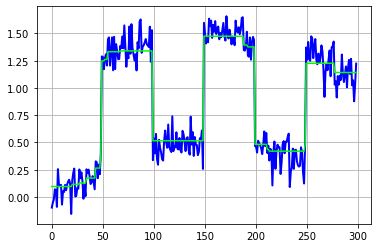

In [29]:
x_corr = np.array([[-0.0975398, -0.05312629, -0.02208009, 0.07036122, 0.05844751, -0.09111081,
                    0.25524962, 0.11391867, 0.0960413,  0.11087175, -0.07009398, 0.05289032,
                    0.04535016, 0.11058097, 0.06159582, 0.11416539, 0.14135736, 0.15779885,
                    0.11841745, -0.15573929, 0.1497802, 0.21942491, 0.26002953, 0.00406207,
                    0.01076279, 0.08560526, 0.0758106,  0.25218958, 0.17094868, 0.22549197,
                    0.14582193, 0.04450351 - 0.06080554, 0.10889565, 0.00731979, 0.25383178,
                    0.21807304, 0.25086839, 0.18829612, 0.11829805, 0.13624649, 0.19156383,
                    0.13209717, 0.06982474, 0.32671382, 0.31943926, 0.17156955, 0.29698227,
                    0.20784119, 0.39387925, 1.28915111, 1.28466809, 1.17170899, 1.27276483,
                    1.30876264, 1.20624095, 1.4475541,  1.46402195, 1.20518098, 1.33903493,
                    1.46396276, 1.16194968, 1.46954723, 1.17276413, 1.40154012, 1.3344524,
                    1.26395560, 1.26554295, 1.38484967, 1.36392024, 1.47217226, 1.36321748,
                    1.57373381, 1.37651055, 1.19416729, 1.33185537, 1.27173017, 1.56374847,
                    1.31351920, 1.58509611, 1.37037572, 1.31357229, 1.25089095, 1.30896004,
                    1.16045129, 1.4191379,  1.36266027, 1.6084522,  1.62853032, 1.3224233,
                    1.37852896, 1.39204502, 1.41821484, 1.4482654,  1.40243864, 1.38977182,
                    1.37571206, 1.56182708, 1.23933557, 1.53008693, 0.33778563, 0.53671323,
                    0.39959707, 0.57810608, 0.34714623, 0.29574822, 0.52339211, 0.45073105,
                    0.40999754, 0.34623906, 0.33349269, 0.51698474, 0.60916496, 0.49911337,
                    0.45151697, 0.66435914, 0.45909372, 0.43361937, 0.4120461,  0.73994126,
                    0.42003412, 0.46914222, 0.45475553, 0.59319831, 0.44271781, 0.43542827,
                    0.54085238, 0.4293042,  0.40759905, 0.60673875, 0.57559843, 0.50406625,
                    0.42045591, 0.54069747, 0.54812155, 0.43266464, 0.3882286,  0.73634181,
                    0.48057600, 0.59402863, 0.37636053, 0.54966699, 0.48076493, 0.47702163,
                    0.38324708, 0.41276572, 0.5387545,  0.52499184, 0.60955938, 0.2569498,
                    1.59757400, 1.49974750, 1.40716928, 1.45590647, 1.41881918, 1.63509243,
                    1.56638179, 1.61757557, 1.45918297, 1.5779364,  1.51591186, 1.61326905,
                    1.49489181, 1.54304499, 1.56310244, 1.44630669, 1.50400512, 1.46626777,
                    1.53122419, 1.5964117,  1.47436147, 1.43470409, 1.65776344, 1.5155677,
                    1.45429071, 1.53389094, 1.47690731, 1.40044678, 1.46996803, 1.46289985,
                    1.39214378, 1.61761391, 1.52735972, 1.50968299, 1.55671309, 1.49293167,
                    1.53236883, 1.64304662, 1.6484901,  1.34768638, 1.34205666, 1.37332403,
                    1.5150243,  1.29612487, 1.28611079, 1.46331723, 1.25927328, 1.42103747,
                    1.46826865, 1.44057849, 0.46655008, 0.46351578, 0.40746583, 0.51540203,
                    0.49632221, 0.4754424,  0.4461718,  0.3927947,  0.47569079, 0.60111625,
                    0.46577111, 0.58634933, 0.4030563,  0.47001092, 0.33429442, 0.44149961,
                    0.41634793, 0.10497809, 0.41269741, 0.50849201, 0.25793693, 0.41901946,
                    0.47958449, 0.45448622, 0.4556222,  0.21116683, 0.31353546, 0.48157662,
                    0.51232681, 0.40093506, 0.50693641, 0.50623056, 0.55246491, 0.58091882,
                    0.09088771, 0.23097229, 0.27061655, 0.44344447, 0.25751509, 0.42937313,
                    0.43329958, 0.32736408, 0.29068132, 0.27797564, 0.28634859, 0.45557439,
                    0.4079212,  0.22503599, 0.12318214, 0.47911303, 1.3711563,  1.25869232,
                    1.42184876, 1.26588232, 1.2496218,  1.47368919, 1.45357969, 1.27337315,
                    1.38442839, 1.44858353, 1.25867526, 1.21725032, 1.31520763, 1.23095494,
                    1.27825279, 1.39025742, 1.33612252, 1.16553053, 0.91782687, 1.14797106,
                    1.2204012,  1.16296689, 1.26227372, 1.34358803, 1.10705193, 1.37268357,
                    1.38178853, 1.42554157, 1.02966171, 1.06281221, 0.91270071, 1.10881591,
                    1.03056827, 1.11251789, 1.07339657, 1.30644577, 1.12965944, 1.05443219,
                    1.12534765, 1.19720807, 1.00582764, 1.18393038, 1.25752049, 1.12823257,
                    1.26705351, 1.02434442, 1.07000497, 0.87731374, 1.03442913, 1.22304696]]).T
n = len(x_corr)

plt.figure()
plt.plot(x_corr, linewidth=2, color='b')

# Create the discrete derivative operator
D = -np.eye(n-1, n).T
np.fill_diagonal(D[1:, :n+1], 1)
D = D.T

x_corr = x_corr.reshape([n, 1])
lmda = 1.8

# Use cvxpy to solve the cvx optimisation problem
x = cvx.Variable((n, 1))
objective = cvx.Minimize(cvx.sum(pow(x - x_corr, 2)) + lmda * cvx.norm1(D @ x))
constraints = []
p = cvx.Problem(objective, constraints)
p.solve()

plt.plot(x.value, c='lime')

plt.grid()
plt.show()
